In [1]:
import torch
import matplotlib.pyplot as plt
from tqdm import tqdm

import sys

sys.path.append("../")

from data import generate_segp_dataset, autocorrelation
from neural_networks.bayesian_nn import HamiltonianPerceptron

torch.set_default_dtype(torch.float64)
plt.style.use('ggplot')

In [2]:
%load_ext autoreload
%autoreload 2

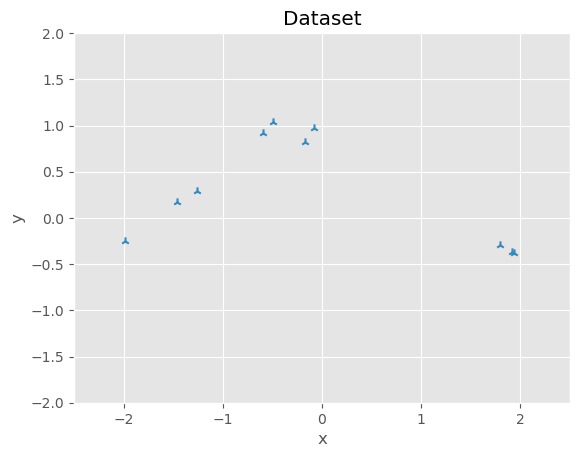

In [3]:
# torch.manual_seed(3)
# x, y = generate_segp_dataset(input_lower=-2.0, input_upper=2.0, num_points=50, noise_level=0.05, lengthscale=1.0)
torch.manual_seed(49)
x, y = generate_segp_dataset(input_lower=-2.0, input_upper=2.0, num_points=10, noise_level=0.1, lengthscale=1.0)

plt.scatter(x, y, color='C1', marker='2')
plt.ylim([-2.0, 2.0])
plt.xlim([-2.5, 2.5])
plt.grid(True)
plt.title('Dataset')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

In [31]:
granularity = 21
stepsizes = torch.logspace(-2.1, -4, granularity)
alphas = torch.zeros((granularity,))
net = HamiltonianPerceptron(100, nonlinearity='tanh', prior='Gaussian', bias=True)

progress = tqdm(enumerate(stepsizes))
for i, stepsize in progress:
    _, alpha, _ = net.hamiltonian_monte_carlo(x, y, simulation_steps=50, step_size=stepsize, leapfrog_steps=1000, pbar=False, metropolis_adjust=True)
    alphas[i] = alpha
    progress.set_postfix({"acceptance": alpha})

0it [00:00, ?it/s]

21it [21:34, 61.62s/it, acceptance=1]   


In [34]:
alphas = torch.flip(alphas, dims=(0,))

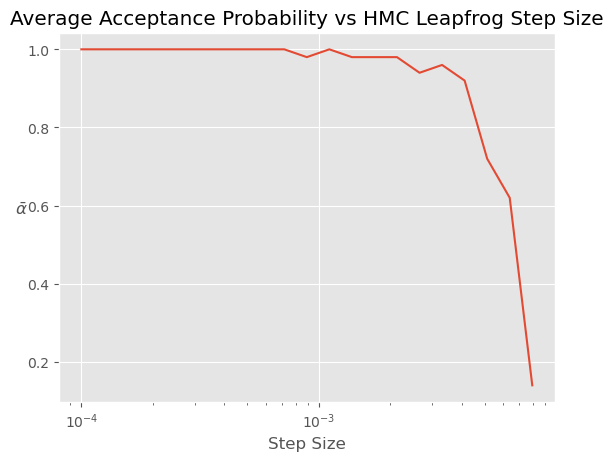

In [35]:
plt.plot(stepsizes, alphas)
plt.title('Average Acceptance Probability vs HMC Leapfrog Step Size')
plt.xlabel('Step Size')
plt.ylabel(r'$\bar{\alpha}$', rotation=0)
plt.xscale('log')
plt.show()

In [19]:
net = HamiltonianPerceptron(100, nonlinearity='tanh', prior='Gaussian', bias=True)
steps = 1000
posterior_samples, alpha, metrics = net.hamiltonian_monte_carlo(x, y, simulation_steps=steps, step_size=1e-4, leapfrog_steps=5000, metropolis_adjust=True)
print(alpha)

100%|██████████| 1000/1000 [1:50:39<00:00,  6.64s/it, log potential=413, average acceptance=1]


1.0


In [20]:
log_potentials = torch.zeros((steps,))
for i, sample in tqdm(enumerate(posterior_samples)):
    with torch.no_grad():
        log_potentials[i] = net.get_potential(x, y, sample)

1000it [00:00, 2244.35it/s]


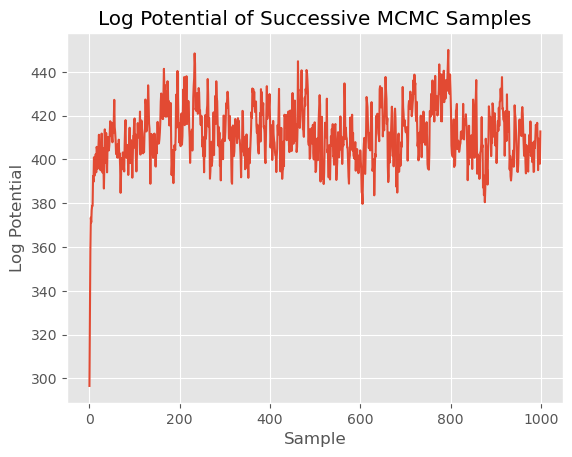

In [21]:
plt.plot(log_potentials)
plt.title('Log Potential of Successive MCMC Samples')
plt.xlabel('Sample')
plt.ylabel('Log Potential')
plt.show()

### Assess correlation between successive samples

In [22]:
burn_in = 10
# burn_in = 0

In [23]:
max_lag = 30
autocorrs = []
lags = [*range(max_lag)]
for lag in tqdm(lags):
    with torch.no_grad():
        autocorrs.append(autocorrelation(posterior_samples[burn_in:], lag=lag).mean())

  0%|          | 0/30 [00:00<?, ?it/s]

100%|██████████| 30/30 [00:00<00:00, 197.68it/s]


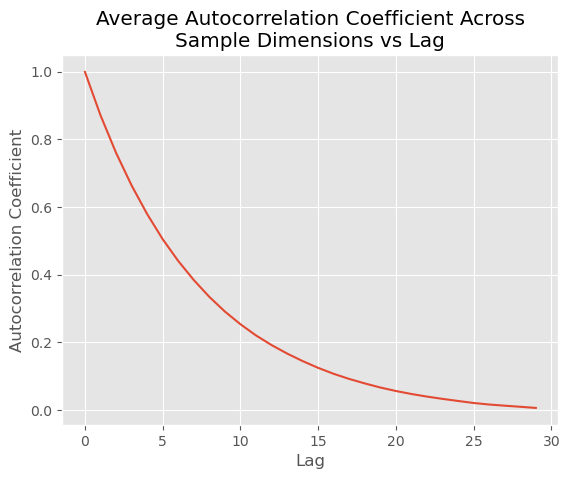

In [24]:
plt.plot(lags, autocorrs)
plt.title('Average Autocorrelation Coefficient Across\nSample Dimensions vs Lag')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation Coefficient')
plt.show()

### Visualise the Posterior Predictive

In [29]:
thin = 10  # this should be around 25
burn_in = 10
useful_samples = posterior_samples[burn_in:][::thin]
print("Number of Useful Samples: ", useful_samples.shape[0])

Number of Useful Samples:  99


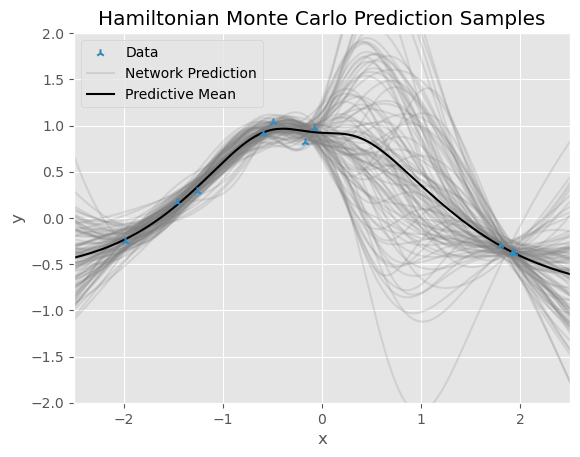

In [30]:
test_x = torch.linspace(-2.5, 2.5, 500)
pred_samps = torch.zeros((useful_samples.shape[0], 500))

plt.scatter(x, y, color='C1', marker='2', label='Data', zorder=1000)
for i, sample in enumerate(useful_samples):
    with torch.no_grad():
        net.sample_to_params(sample)
        preds = net(test_x)
        pred_samps[i,:] = preds.squeeze()
    if i == 0:
        label = 'Network Prediction'
    else:
        label = None
    plt.plot(test_x, preds, color='grey', label=label, alpha=0.2)
    
plt.plot(test_x, pred_samps.mean(dim=0), color='black', label='Predictive Mean', alpha=1.0)
    
plt.ylim([-2.0, 2.0])
plt.xlim([-2.5, 2.5])
plt.grid(True)
plt.title('Hamiltonian Monte Carlo Prediction Samples')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()